# **Predictive Analysis #1**

>***UC-Irvine Online Shoppers Purchasing Intention Dataset***

* Using all independent variables without applying any feature selection techniques

#Importing libraries and dataset

**Importing required libraries**

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import copy

from pandas.core.frame import DataFrame
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import plot_confusion_matrix



**Reading the dataset to Pandas dataframe**

In [119]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
df_original = pd.read_csv (url)

**Making a copy to keep the original if needed.**

In [120]:
df_c=df_original.copy()

# Preprocessing the dataset

**Data Normalization**

In [121]:
from sklearn.preprocessing import Normalizer
#defining the preprocessor 
Normalizer=Normalizer()

#creating a list of numerical features 
numeric_features = ["Administrative", "Administrative_Duration", 
                    "Informational", "Informational_Duration", "ProductRelated",
                     "ProductRelated_Duration", "BounceRates", 
                    "ExitRates", "PageValues", "SpecialDay", 
                    "Browser","Region", "OperatingSystems","TrafficType"  ]

#normalizing the numerical features 
df_c[numeric_features]=Normalizer.fit_transform(df_c[numeric_features])


**Creating a temporary dataframe from only the dependent variable so it can be re-added as the last column of the finalized dataframe**

In [122]:
y=df_c[["Revenue"]]


**Transforming the non-numeric categorical features to dummy variables**

In [123]:
#Defining dummy values for all non-numeric  categorical variables 
Month=pd.get_dummies(df_c["Month"], drop_first=True)
VisitorType=pd.get_dummies(df_c["VisitorType"], drop_first=True)
Weekend=pd.get_dummies(df_c["Weekend"],  prefix="Weekend", drop_first=True)

**Dropping the original variables, and dependent variable (so it can be added back as the last column)**

In [124]:
#dropping the original variables, and dependent variable (so it can be added back as the last column)
df_c.drop(["Month", "VisitorType", "Weekend", "Revenue"], axis=1, inplace=True)

**Adding the newly created dummy variables to the dataset, and adding dependent variable to the end**

In [125]:
#adding the newly created dummy variables to the dataset, and adding dependent variable to the end
df_c=pd.concat([df_c, Month, VisitorType, Weekend, y],axis=1)

**Let's take a look at the transformed dataset before we proceed**

In [126]:
df_c

Administrative  Administrative_Duration  Informational  \
0            0.000000                 0.000000            0.0   
1            0.000000                 0.000000            0.0   
2            0.000000                 0.000000            0.0   
3            0.000000                 0.000000            0.0   
4            0.000000                 0.000000            0.0   
...               ...                      ...            ...   
12325        0.001675                 0.080982            0.0   
12326        0.000000                 0.000000            0.0   
12327        0.000000                 0.000000            0.0   
12328        0.011281                 0.211524            0.0   
12329        0.000000                 0.000000            0.0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0        0.443678                 0.000000   
1                         0.0        0.031185                 0.997930   
2                         0.0        0.096189                 0.000000   
3                         0.0        0.301056                 0.401408   
4                         0.0        0.015934                 0.999829   
...                       ...             ...                      ...   
12325                     0.0        0.029600                 0.996243   
12326                     0.0        0.010733                 0.999763   
12327                     0.0        0.032460                 0.996790   
12328                     0.0        0.042305                 0.975829   
12329                     0.0        0.137136                 0.971376   

       BounceRates  ExitRates  PageValues  SpecialDay  ...  June  Mar  May  \
0         0.088736   0.088736    0.000000         0.0  ...     0    0    0   
1         0.000000   0.001559    0.000000         0.0  ...     0    0    0   
2         0.019238   0.019238    0.000000         0.0  ...     0    0    0   
3         0.007526   0.021074    0.000000         0.0  ...     0    0    0   
4         0.000032   0.000080    0.000000         0.0  ...     0    0    0   
...            ...        ...         ...         ...  ...   ...  ...  ...   
12325     0.000004   0.000016    0.006837         0.0  ...     0    0    0   
12326     0.000000   0.000046    0.000000         0.0  ...     0    0    0   
12327     0.000451   0.000469    0.000000         0.0  ...     0    0    0   
12328     0.000000   0.000059    0.000000         0.0  ...     0    0    0   
12329     0.000000   0.003047    0.000000         0.0  ...     0    0    0   

       Nov  Oct  Sep  Other  Returning_Visitor  Weekend_True  Revenue  
0        0    0    0      0                  1             0    False  
1        0    0    0      0                  1             0    False  
2        0    0    0      0                  1             0    False  
3        0    0    0      0                  1             0    False  
4        0    0    0      0                  1             1    False  
...    ...  ...  ...    ...                ...           ...      ...  
12325    0    0    0      0                  1             1    False  
12326    1    0    0      0                  1             1    False  
12327    1    0    0      0                  1             1    False  
12328    1    0    0      0                  1             0    False  
12329    1    0    0      0                  0             1    False  

[12330 rows x 27 columns]

**In this section we will create a copy of original dataset, and transform  non-numeric dependent variable to intgeres.This copy will only will be used for tasks such as some tyes of plotting, etc. and not in any modelling**

In [127]:
df_extra= df_original.copy()

In [128]:
#creating a list of object features

object_features = ["Month", "VisitorType", "Weekend", "Revenue"]

#converting Month names to the corresponding numbers
Month={'Feb':2, 'Mar':3, 'May':5, 'Oct':10, 'June':6, 'Jul':7, 'Aug':8, 'Nov':11, 'Sep':9,'Dec':12}
df_extra['Month']=df_extra['Month'].map(Month)

#converting visitor types to integers
VisitorType={'Returning_Visitor':1, 'New_Visitor':2, 'Other':3}
df_extra['VisitorType']=df_extra['VisitorType'].map(VisitorType)

#for "Weekend" and "Revenue" we can just replace True and False with 1 & 0 respectively 
df_extra.replace({True:1,False:0})

Administrative  Administrative_Duration  Informational  \
0                   0                      0.0              0   
1                   0                      0.0              0   
2                   0                      0.0              0   
3                   0                      0.0              0   
4                   0                      0.0              0   
...               ...                      ...            ...   
12325               3                    145.0              0   
12326               0                      0.0              0   
12327               0                      0.0              0   
12328               4                     75.0              0   
12329               0                      0.0              0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0               1                 0.000000   
1                         0.0               2                64.000000   
2                         0.0               1                 0.000000   
3                         0.0               2                 2.666667   
4                         0.0              10               627.500000   
...                       ...             ...                      ...   
12325                     0.0              53              1783.791667   
12326                     0.0               5               465.750000   
12327                     0.0               6               184.250000   
12328                     0.0              15               346.000000   
12329                     0.0               3                21.250000   

       BounceRates  ExitRates  PageValues  SpecialDay  Month  \
0         0.200000   0.200000    0.000000         0.0      2   
1         0.000000   0.100000    0.000000         0.0      2   
2         0.200000   0.200000    0.000000         0.0      2   
3         0.050000   0.140000    0.000000         0.0      2   
4         0.020000   0.050000    0.000000         0.0      2   
...            ...        ...         ...         ...    ...   
12325     0.007143   0.029031   12.241717         0.0     12   
12326     0.000000   0.021333    0.000000         0.0     11   
12327     0.083333   0.086667    0.000000         0.0     11   
12328     0.000000   0.021053    0.000000         0.0     11   
12329     0.000000   0.066667    0.000000         0.0     11   

       OperatingSystems  Browser  Region  TrafficType  VisitorType  Weekend  \
0                     1        1       1            1            1        0   
1                     2        2       1            2            1        0   
2                     4        1       9            3            1        0   
3                     3        2       2            4            1        0   
4                     3        3       1            4            1        1   
...                 ...      ...     ...          ...          ...      ...   
12325                 4        6       1            1            1        1   
12326                 3        2       1            8            1        1   
12327                 3        2       1           13            1        1   
12328                 2        2       3           11            1        0   
12329                 3        2       1            2            2        1   

       Revenue  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
12325        0  
12326        0  
12327        0  
12328        0  
12329        0  

[12330 rows x 18 columns]

**Plotting the probability distribution (Q-Q) for all features to detect outliers**

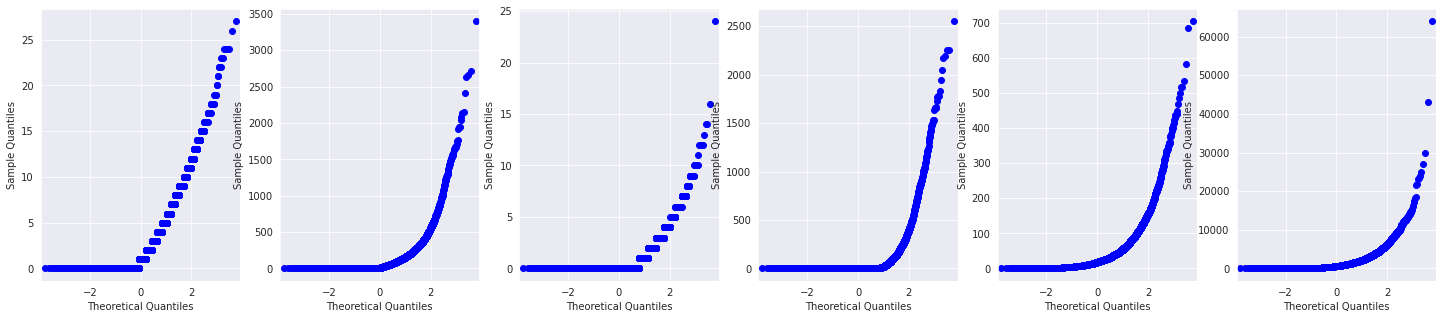

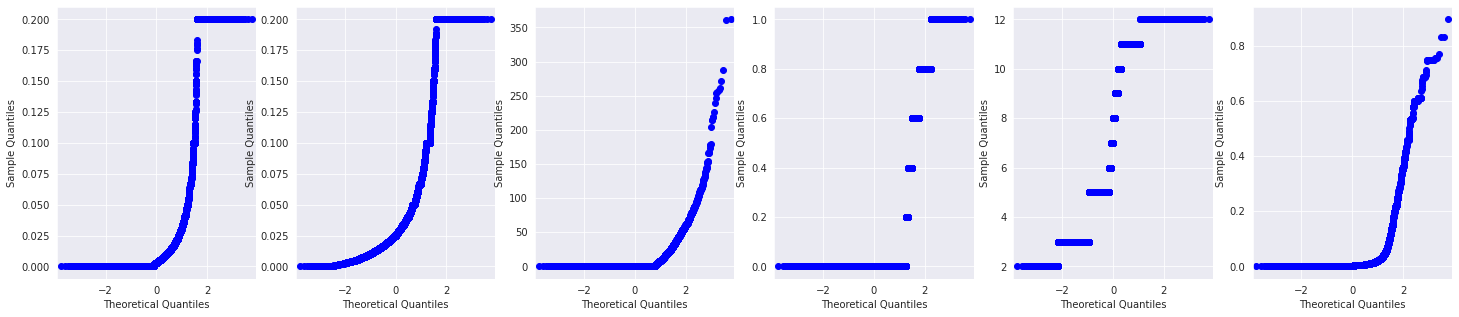

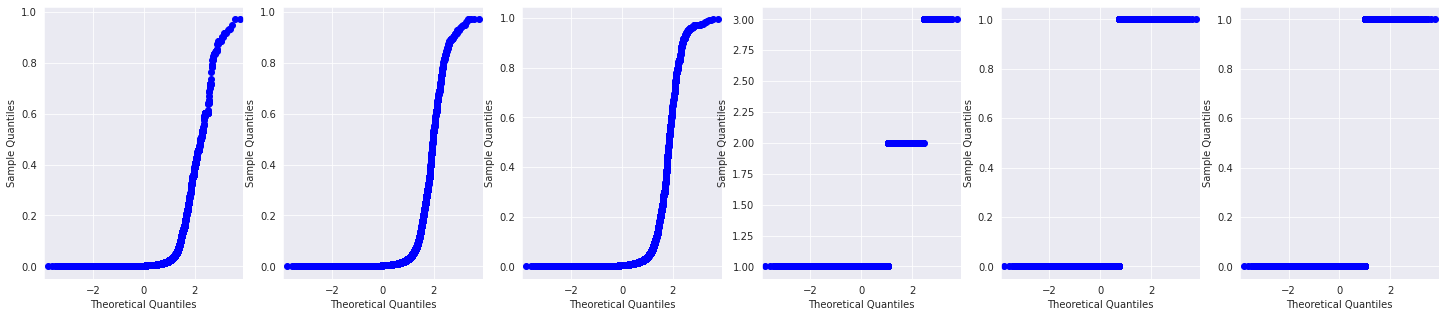

In [129]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(1, 6, figsize=(25, 5))
sm.ProbPlot(df_original["Administrative"]).qqplot(  ax=ax[0])
sm.ProbPlot(df_original["Administrative_Duration"]).qqplot( ax=ax[1])
sm.ProbPlot(df_original["Informational"]).qqplot( ax=ax[2]);
sm.ProbPlot(df_original["Informational_Duration"]).qqplot( ax=ax[3]);
sm.ProbPlot(df_original["ProductRelated"]).qqplot( ax=ax[4]);
sm.ProbPlot(df_original["ProductRelated_Duration"]).qqplot( ax=ax[5]);

fig, ax = plt.subplots(1, 6, figsize=(25, 5))
sm.ProbPlot(df_original["BounceRates"]).qqplot(  ax=ax[0])
sm.ProbPlot(df_original["ExitRates"]).qqplot( ax=ax[1])
sm.ProbPlot(df_original["PageValues"]).qqplot( ax=ax[2]);
sm.ProbPlot(df_original["SpecialDay"]).qqplot( ax=ax[3]);
sm.ProbPlot(df_extra["Month"]).qqplot( ax=ax[4]);
sm.ProbPlot(df_c["OperatingSystems"]).qqplot( ax=ax[5]);


fig, ax = plt.subplots(1, 6, figsize=(25, 5))
sm.ProbPlot(df_c["Browser"]).qqplot(  ax=ax[0])
sm.ProbPlot(df_c["Region"]).qqplot( ax=ax[1])
sm.ProbPlot(df_c["TrafficType"]).qqplot( ax=ax[2]);
sm.ProbPlot(df_extra["VisitorType"]).qqplot( ax=ax[3]);
sm.ProbPlot(df_extra["Weekend"]).qqplot( ax=ax[4]);
sm.ProbPlot(df_extra["Revenue"]).qqplot( ax=ax[5]);


* There are no outliers to be removed.The distribution, as we seen before, are not normal and are skewed for numerical features, however there is no anamoly in data points. Please note that the google analytics features are not collected manually hence there is no chance of mistake within those data. 

#ML Parameters

* **we set random state for the result to be repeatable**

In [130]:
# Set a Random State 
rng = np.random.RandomState(0)


* **Let's separate our dependent variable, and split our data to train set and test set.** 
* **we will keep this 20% test set to evaluate and compare the performance of  all models.**

In [131]:
from sklearn.model_selection import train_test_split
# Divide X and y (separating dependent variable from independent variables)
y = df_c['Revenue']
X = df_c.drop(['Revenue'], axis=1)

# Split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=rng)

* **We will use Accuracy,precision, recall, F1 score, and AUC-ROC(Area Under the Curve of Receiver Operating Characteristics) as evaluation measure to compare our models.**
* **We are also using 10 fold cross validation, repeated 3 times, to train our models. Please note we set randm_state to ensure our folds stay the same for all models.**

In [132]:
#creating a list of evaluation measures to pass on to ML pipelines
scoring = ('roc_auc','accuracy','precision','recall', "f1")

#creating repeated K fold Cross validation with random state to pass on to ML pieplines 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=rng)

#Base Model

**Let's pass on the data to XGB  (Extreme Gradient Boosting) Classifier as base model**

In [133]:
#defining the classifier 
base_model=XGBClassifier(eval_metric='logloss', max_depth=17)

#steps in the pipeline (here we only have the classifier as base model)
steps=[("classifier", base_model)]

#defining the pipeline
clf_base= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_base = cross_validate(clf_base, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation 
for k, v in scores_base.items():
    print(k, np.round(v.mean(),4))

fit_time 5.4025
score_time 0.0315
test_roc_auc 0.927
test_accuracy 0.9
test_precision 0.7001
test_recall 0.588
test_f1 0.6383


* **We see the average result of all folds performed by using the training and validation set of each fold**

**Since the results are acceptable, in the next step, we pass on the test set to assess our model, and calculate the evaluation measures which would be the measures to compare the performance of the models on unseen data** 

P.S. We  won't use the base model for model comparison as it's biased towards the majority class. This is only to set up all the steps that will be followed throughout the predictive analysis. 

In [134]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
base_fit=base_model.fit(X_train, y_train)

**Predicting the independent variable "Revenue" using test set**

In [135]:
from sklearn.metrics import confusion_matrix, accuracy_score

#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_base = base_fit.predict(X_test)


**Displaying the results as Confusion Matrix**

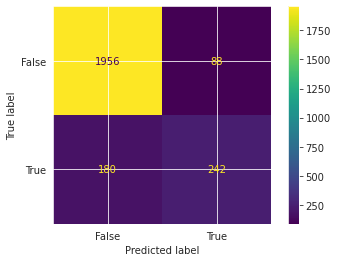

In [136]:

from sklearn.metrics import ConfusionMatrixDisplay

#Displaying the results as Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base);

**Let's get the evaluation measures for the model:**

In [137]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

#printing the evaluation measures for test set
print("base_model=XGBClassifier\n\n", classification_report(y_test, y_pred_base, digits=3))
print("roc_auc    ", round(roc_auc_score(y_test, y_pred_base), 3))

base_model=XGBClassifier

               precision    recall  f1-score   support

       False      0.916     0.957     0.936      2044
        True      0.733     0.573     0.644       422

    accuracy                          0.891      2466
   macro avg      0.825     0.765     0.790      2466
weighted avg      0.885     0.891     0.886      2466

roc_auc     0.765


* **It should be noted that this was only a base model. We will train our models with another step added below.**

* **As shown in the EDA, our data set is extremely imbalanced. Hence, we will apply SMOTE on our train dataset before training each model. For this purpose, we add the SMOTE function to all our Machine Learning pieplines going forward.**

**NOTE: All the above steps will be repeated for each model.**

#XGB Classifier

In [138]:
#defining the classifier 
XGB=XGBClassifier(eval_metric='logloss', max_depth=27)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", XGB)]

#defining the pipeline
clf_XGB= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_XGB = cross_validate(clf_XGB, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_XGB.items():
    print(k, np.round(v.mean(),4))


fit_time 12.104
score_time 0.0351
test_roc_auc 0.9252
test_accuracy 0.8851
test_precision 0.595
test_recall 0.7431
test_f1 0.6603


In [139]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
XGB_fit=XGB.fit(X_train, y_train)


In [140]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_XGB = XGB_fit.predict(X_test)

In [141]:
# Confusion Matrix
cm_XGB=confusion_matrix(y_test, y_pred_XGB)
cm_XGB

array([[1963,   81],
       [ 177,  245]])

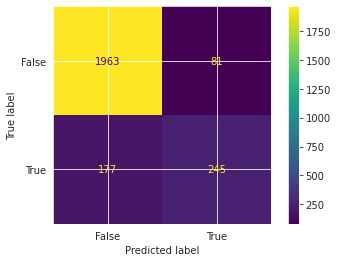

In [142]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_XGB);

In [143]:
#getting the evaluation measures for test set
XGB_Metrics= classification_report(y_test, y_pred_XGB, digits=3)
XGB_ROC_AUC= round(roc_auc_score(y_test, y_pred_XGB),3)

#printing the evaluation measures for test set
print("XGBClassifier\n\n", XGB_Metrics)
print("roc_auc    ", XGB_ROC_AUC )

XGBClassifier

               precision    recall  f1-score   support

       False      0.917     0.960     0.938      2044
        True      0.752     0.581     0.655       422

    accuracy                          0.895      2466
   macro avg      0.834     0.770     0.797      2466
weighted avg      0.889     0.895     0.890      2466

roc_auc     0.77


In [144]:
#saving the model performance result in a dictionary for easy future access
XGB_report= classification_report(y_test, y_pred_XGB, digits=3, output_dict=True)


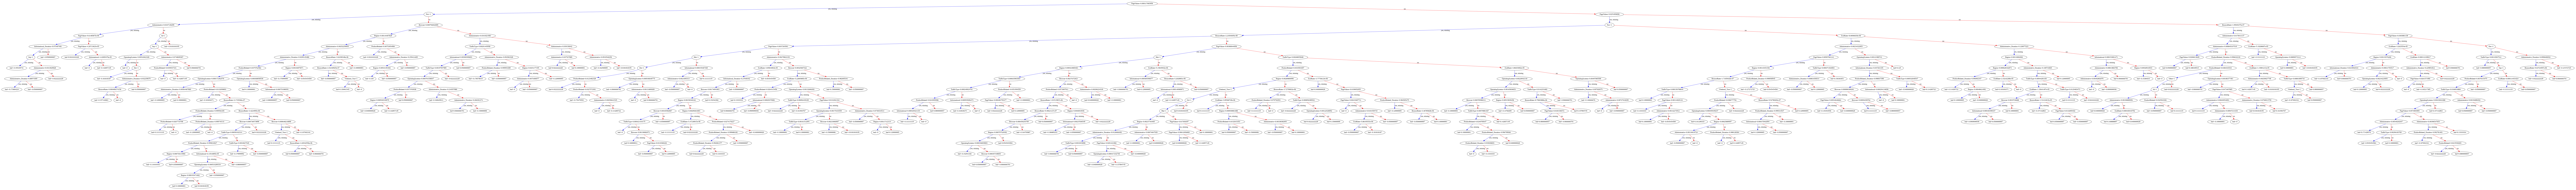

In [145]:
from xgboost import plot_tree
#Plotting the XGB tree
plot_tree(XGB);
fig = plt.gcf()
fig.set_size_inches(300, 300)
fig.savefig('XGBtree.png')

#Random Forest Classifier

In [146]:
from sklearn.ensemble import RandomForestClassifier

#defining the classifier 
RF=RandomForestClassifier(random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", RF)]

#defining the pipeline
clf_RF= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_RF = cross_validate(clf_RF, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_RF.items():
    print(k, np.round(v.mean(),4))

fit_time 3.7012
score_time 0.0816
test_roc_auc 0.9244
test_accuracy 0.8874
test_precision 0.5987
test_recall 0.7655
test_f1 0.6713


In [147]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
RF_fit=RF.fit(X_train, y_train)

In [148]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_RF = RF_fit.predict(X_test)

In [149]:
# Confusion Matrix
cm_RF=confusion_matrix(y_test, y_pred_RF)
cm_RF

array([[1970,   74],
       [ 198,  224]])

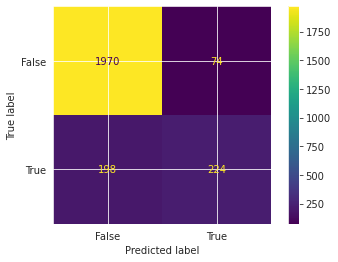

In [150]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF);

In [151]:
#getting the evaluation measures for test set
RF_Metrics= classification_report(y_test, y_pred_RF, digits=3)
RF_ROC_AUC= round(roc_auc_score(y_test, y_pred_RF),3)

#printing the evaluation measures for test set
print("RandomForestClassifier\n\n", RF_Metrics)
print("roc_auc    ", RF_ROC_AUC )

RandomForestClassifier

               precision    recall  f1-score   support

       False      0.909     0.964     0.935      2044
        True      0.752     0.531     0.622       422

    accuracy                          0.890      2466
   macro avg      0.830     0.747     0.779      2466
weighted avg      0.882     0.890     0.882      2466

roc_auc     0.747


In [152]:
#saving the model performance result in a dictionary for easy future access
RF_report= classification_report(y_test, y_pred_RF, digits=3, output_dict=True)

#Desicion Tree Classifier

In [153]:
#defining the classifier 
DT=DecisionTreeClassifier(random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", DT)]

#defining the pipeline
clf_DT= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_DT = cross_validate(clf_DT, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_DT.items():
    print(k, np.round(v.mean(),4))

fit_time 0.3705
score_time 0.0094
test_roc_auc 0.777
test_accuracy 0.8534
test_precision 0.5107
test_recall 0.6676
test_f1 0.578


In [154]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
DT_fit= DT.fit(X_train, y_train)


In [155]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_DT = DT_fit.predict(X_test)

In [156]:
# Confusion Matrix
cm_DT=confusion_matrix(y_test, y_pred_DT)
cm_DT

array([[1884,  160],
       [ 193,  229]])

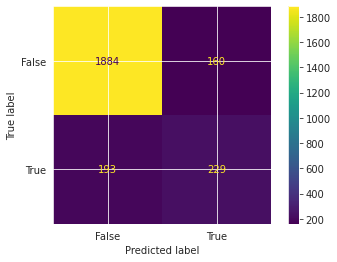

In [157]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_DT);

In [158]:
#getting the evaluation measures for test set
DT_Metrics= classification_report(y_test, y_pred_DT, digits=3)
DT_ROC_AUC= round(roc_auc_score(y_test, y_pred_DT),3)

#printing the evaluation measures for test set
print("DecisionTreeClassifier\n\n", DT_Metrics)
print("roc_auc    ", DT_ROC_AUC )

DecisionTreeClassifier

               precision    recall  f1-score   support

       False      0.907     0.922     0.914      2044
        True      0.589     0.543     0.565       422

    accuracy                          0.857      2466
   macro avg      0.748     0.732     0.740      2466
weighted avg      0.853     0.857     0.855      2466

roc_auc     0.732


In [159]:
#saving the model performance result in a dictionary for easy future access
DT_report= classification_report(y_test, y_pred_DT, digits=3, output_dict=True)

#Support Vector Classification

In [160]:
from sklearn import svm

#defining the classifier 
SVC_L=svm.SVC(kernel='linear', random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", SVC_L)]

#defining the pipeline
clf_SVC_L= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_SVC_L = cross_validate(clf_SVC_L, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_SVC_L.items():
    print(k, np.round(v.mean(),4))

fit_time 9.1082
score_time 0.6506
test_roc_auc 0.858
test_accuracy 0.7752
test_precision 0.3684
test_recall 0.6862
test_f1 0.4789


In [161]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
SVC_fit=SVC_L.fit(X_train, y_train)


In [162]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_SVC_L = SVC_fit.predict(X_test)

In [163]:
# Confusion Matrix
cm_SVC_L=confusion_matrix(y_test, y_pred_SVC_L)
cm_SVC_L

array([[2029,   15],
       [ 353,   69]])

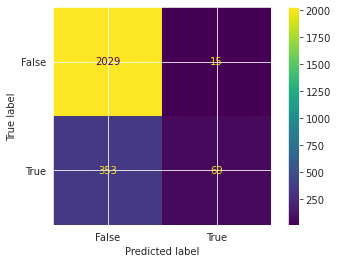

In [164]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_SVC_L);

In [165]:
#getting the evaluation measures for test set
SVC_L_Metrics= classification_report(y_test, y_pred_SVC_L, digits=3)
SVC_L_ROC_AUC= round(roc_auc_score(y_test, y_pred_SVC_L),3)

#printing the evaluation measures for test set
print("Support Vector Classification \n\n", SVC_L_Metrics)
print("roc_auc    ", SVC_L_ROC_AUC )

Support Vector Classification 

               precision    recall  f1-score   support

       False      0.852     0.993     0.917      2044
        True      0.821     0.164     0.273       422

    accuracy                          0.851      2466
   macro avg      0.837     0.578     0.595      2466
weighted avg      0.847     0.851     0.807      2466

roc_auc     0.578


In [166]:
#saving the model performance result in a dictionary for easy future access
SVC_L_report= classification_report(y_test, y_pred_SVC_L, digits=3, output_dict=True)

#LogisticRegression

In [167]:
from sklearn.linear_model import LogisticRegression

#defining the classifier 
LR=LogisticRegression(random_state=rng, max_iter=2000)

#steps in the pipeline 
steps=[('SMOTE', SMOTE( random_state=rng)),("classifier", LR)]

#defining the pipeline
clf_LR= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_LR = cross_validate(clf_LR, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_LR.items():
    print(k, np.round(v.mean(),4))

fit_time 0.5934
score_time 0.0148
test_roc_auc 0.8512
test_accuracy 0.772
test_precision 0.3715
test_recall 0.7424
test_f1 0.4945


In [168]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
LR_fit=LR.fit(X_train, y_train)

In [169]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_LR = LR_fit.predict(X_test)

In [170]:
# Confusion Matrix
cm_LR=confusion_matrix(y_test, y_pred_LR)
cm_LR

array([[2035,    9],
       [ 372,   50]])

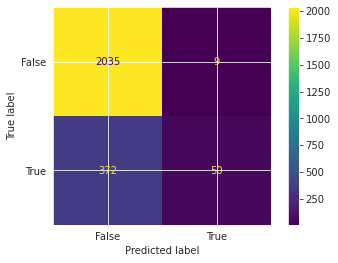

In [171]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_LR);

In [172]:
#getting the evaluation measures for test set
LR_Metrics= classification_report(y_test, y_pred_LR, digits=3)
LR_ROC_AUC= round(roc_auc_score(y_test, y_pred_LR),3)

#printing the evaluation measures for test set
print("Logistic Regression Classifier \n\n", LR_Metrics)
print("roc_auc    ", LR_ROC_AUC )

Logistic Regression Classifier 

               precision    recall  f1-score   support

       False      0.845     0.996     0.914      2044
        True      0.847     0.118     0.208       422

    accuracy                          0.845      2466
   macro avg      0.846     0.557     0.561      2466
weighted avg      0.846     0.845     0.793      2466

roc_auc     0.557


In [173]:
#saving the model performance result in a dictionary for easy future access
LR_report= classification_report(y_test, y_pred_LR, digits=3, output_dict=True)

#Comparing the Models 

In [174]:
from tabulate import tabulate

In [175]:
#create data
data = [["Extreme Gradiant Boosting", XGB_report["accuracy"], XGB_report["False"]["recall"], XGB_report["True"]["recall"], 
         XGB_report["False"]["precision"], XGB_report["True"]["precision"], XGB_report["False"]["f1-score"], XGB_report["True"]["f1-score"], XGB_ROC_AUC],
        
        ["Random Forest", RF_report["accuracy"], RF_report["False"]["recall"], RF_report["True"]["recall"], 
         RF_report["False"]["precision"], RF_report["True"]["precision"], RF_report["False"]["f1-score"], RF_report["True"]["f1-score"], RF_ROC_AUC], 
        
        ["Decision Tree", DT_report["accuracy"], DT_report["False"]["recall"], DT_report["True"]["recall"], 
         DT_report["False"]["precision"], DT_report["True"]["precision"], DT_report["False"]["f1-score"], DT_report["True"]["f1-score"], DT_ROC_AUC], 
        
        ["Support Vector Classifier", SVC_L_report["accuracy"], SVC_L_report["False"]["recall"], SVC_L_report["True"]["recall"], 
         SVC_L_report['False']["precision"], SVC_L_report["True"]["precision"], SVC_L_report["False"]["f1-score"], SVC_L_report["True"]["f1-score"], SVC_L_ROC_AUC],
        
        ["Logistic Regression", LR_report["accuracy"], LR_report["False"]["recall"], LR_report["True"]["recall"], 
         LR_report["False"]["precision"], LR_report["True"]["precision"], LR_report["False"]["f1-score"], LR_report["True"]["f1-score"], LR_ROC_AUC]]
  
#define header names
col_names = ["Classifier", "Accuracy", "Recall (Revenue=False)", "Recall (Revenue=True)", "Precision (Revenue=False)",
             "Precision (Revenue=True)", "F1 (Revenue=False)", "F1 (Revenue=True)", "ROC_AUC"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════════════════╤════════════╤══════════════════════════╤═════════════════════════╤═════════════════════════════╤════════════════════════════╤══════════════════════╤═════════════════════╤═══════════╕
│ Classifier                │   Accuracy │   Recall (Revenue=False) │   Recall (Revenue=True) │   Precision (Revenue=False) │   Precision (Revenue=True) │   F1 (Revenue=False) │   F1 (Revenue=True) │   ROC_AUC │
╞═══════════════════════════╪════════════╪══════════════════════════╪═════════════════════════╪═════════════════════════════╪════════════════════════════╪══════════════════════╪═════════════════════╪═══════════╡
│ Extreme Gradiant Boosting │   0.895377 │                 0.960372 │                0.580569 │                    0.91729  │                   0.751534 │             0.938337 │            0.65508  │     0.77  │
├───────────────────────────┼────────────┼──────────────────────────┼─────────────────────────┼─────────────────────────────┼───────────────────────────

**In this analysis we used all 17 independent variables included in the original dataset**

**In the next predictive analysis we will look into feature selection options and retrain our models.** 